In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import os, glob, yaml, h5py, svmbir

from tqdm import tqdm
import tomopy

In [20]:
from AInCT import *
from AIRobo import *

olefile module not found


In [23]:
angle_list = np.array([7.71082381, 242.5702746, 360, 15.42080578, 237.9102855, 355.3400109, 20.08079488, 230.2003035, 
                       347.6300289, 27.79077685, 217.8303325, 342.9700398, 40.16074792, 210.1203505, 335.2600579, 
                       47.87072989, 205.4603614, 327.5500759, 52.530719, 197.7503794, 322.8900868, 60.24070097, 
                       190.0403974, 315.1801048, 67.95068294, 185.3804083, 302.8101337, 72.61067204, 177.6704264, 
                       295.1001518, 80.32065401, 165.3004553, 290.4401627, 92.69062509, 157.5904733, 282.7301807, 
                       100.4006071, 152.9304842, 275.0201987, 105.0605962, 145.2205023, 270.3602096, 112.7705781, 
                       137.5105203, 262.6502277, 120.4805601, 132.8505312, 257.9902385, 125.1405492, 250.2802566])

10

In [30]:
cfg_file = '/home/gxt/Projects/hype_ipts_33531/configs/config.yaml'
cfg = yaml.safe_load(open(cfg_file, 'r', encoding = 'utf-8'))

In [31]:
data_path = cfg['DataPath']
_exp_name = cfg['experiment_title']
proj_str = f'*{_exp_name}*'

In [32]:
proj_base_folders = glob.glob(os.path.join(data_path, proj_str)) # get new list
proj_paths = gen_paths(proj_base_folders)
run_num = os.path.split(proj_paths[0])[-1]
nuxus_fl = f"/storage/VENUS/IPTS-33531/nexus/{run_num.replace('Run', 'VENUS')}.nxs.h5"

In [ ]:
with h5py.File(nuxus_fl, 'r') as hdf5_data:
    _proton_charge = hdf5_data['entry']["proton_charge"][0]
    print(f"{_proton_charge = }")
    _acq_number = hdf5_data['entry']['DASlogs']['BL10:Det:PIXELMAN:ACQ:NUM']['value'][:][-1]
    print(f"{_acq_number = }")

In [33]:
norm_data, angle_list = ProjLoader(cfg['DataPath'], cfg['ob_local_path'], 
                                   proj_str, cfg['load_paras'], 
                                   cfg['background_cali_paras'], 
                                   cfg['wav_idx_start'][0], cfg['wav_idx_end'][0],
                                   os.path.join(cfg['OutPath'], proj_str[1:-1]), save = True)

['/storage/VENUS/IPTS-33531/images/mcp/OB_November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin/Run_5127', '/storage/VENUS/IPTS-33531/images/mcp/OB_November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin/Run_5128', '/storage/VENUS/IPTS-33531/images/mcp/OB_November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin/Run_5129', '/storage/VENUS/IPTS-33531/images/mcp/OB_November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin/Run_5130', '/storage/VENUS/IPTS-33531/images/mcp/OB_November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin/Run_5131']
OB exists, load /storage/VENUS/IPTS-33531/shared/ai_outputs/November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin_02_50C/OBs/OB_wav_50_800.tiff
Load /storage/VENUS/IPTS-33531/shared/ai_outputs/November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin_02_50C/Projs/wav_50_800/November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin_02_50C_Angle_165_300deg_032.tiff
Load /storage/VENUS/IPTS-33531/shared/ai_outputs/November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin_02_50C/Projs/wav_50_800/November22_CrushedRing_B_hype

Text(0.5, 1.0, 'flipped 242.570˚')

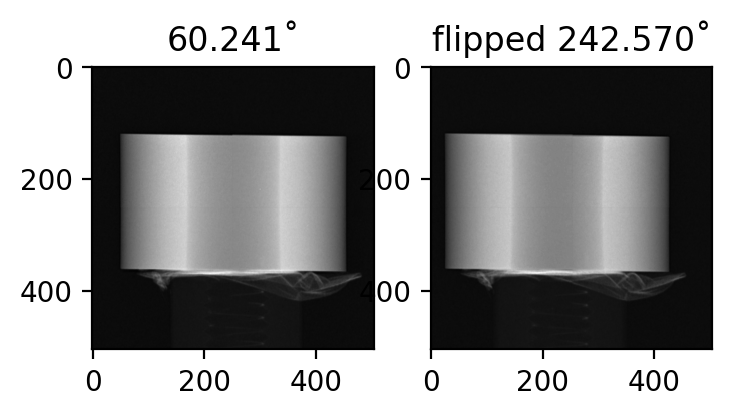

In [44]:
fig, axs = plt.subplots(1,2,figsize=(4, 2), dpi = 200)
axs = axs.flatten()
axs[0].imshow(norm_data[8], cmap='gray')
axs[0].set_title(f'{angle_list[8]:.3f}˚')

axs[1].imshow(np.fliplr(norm_data[33]), cmap='gray')
axs[1].set_title(f'flipped {angle_list[33]:.3f}˚')

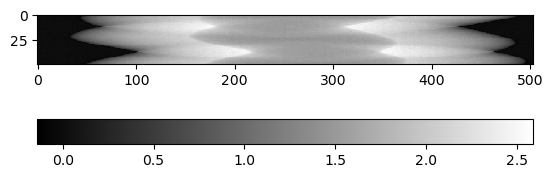

In [42]:
plt.imshow(norm_data[:, 252], cmap='gray')
plt.colorbar(orientation='horizontal')

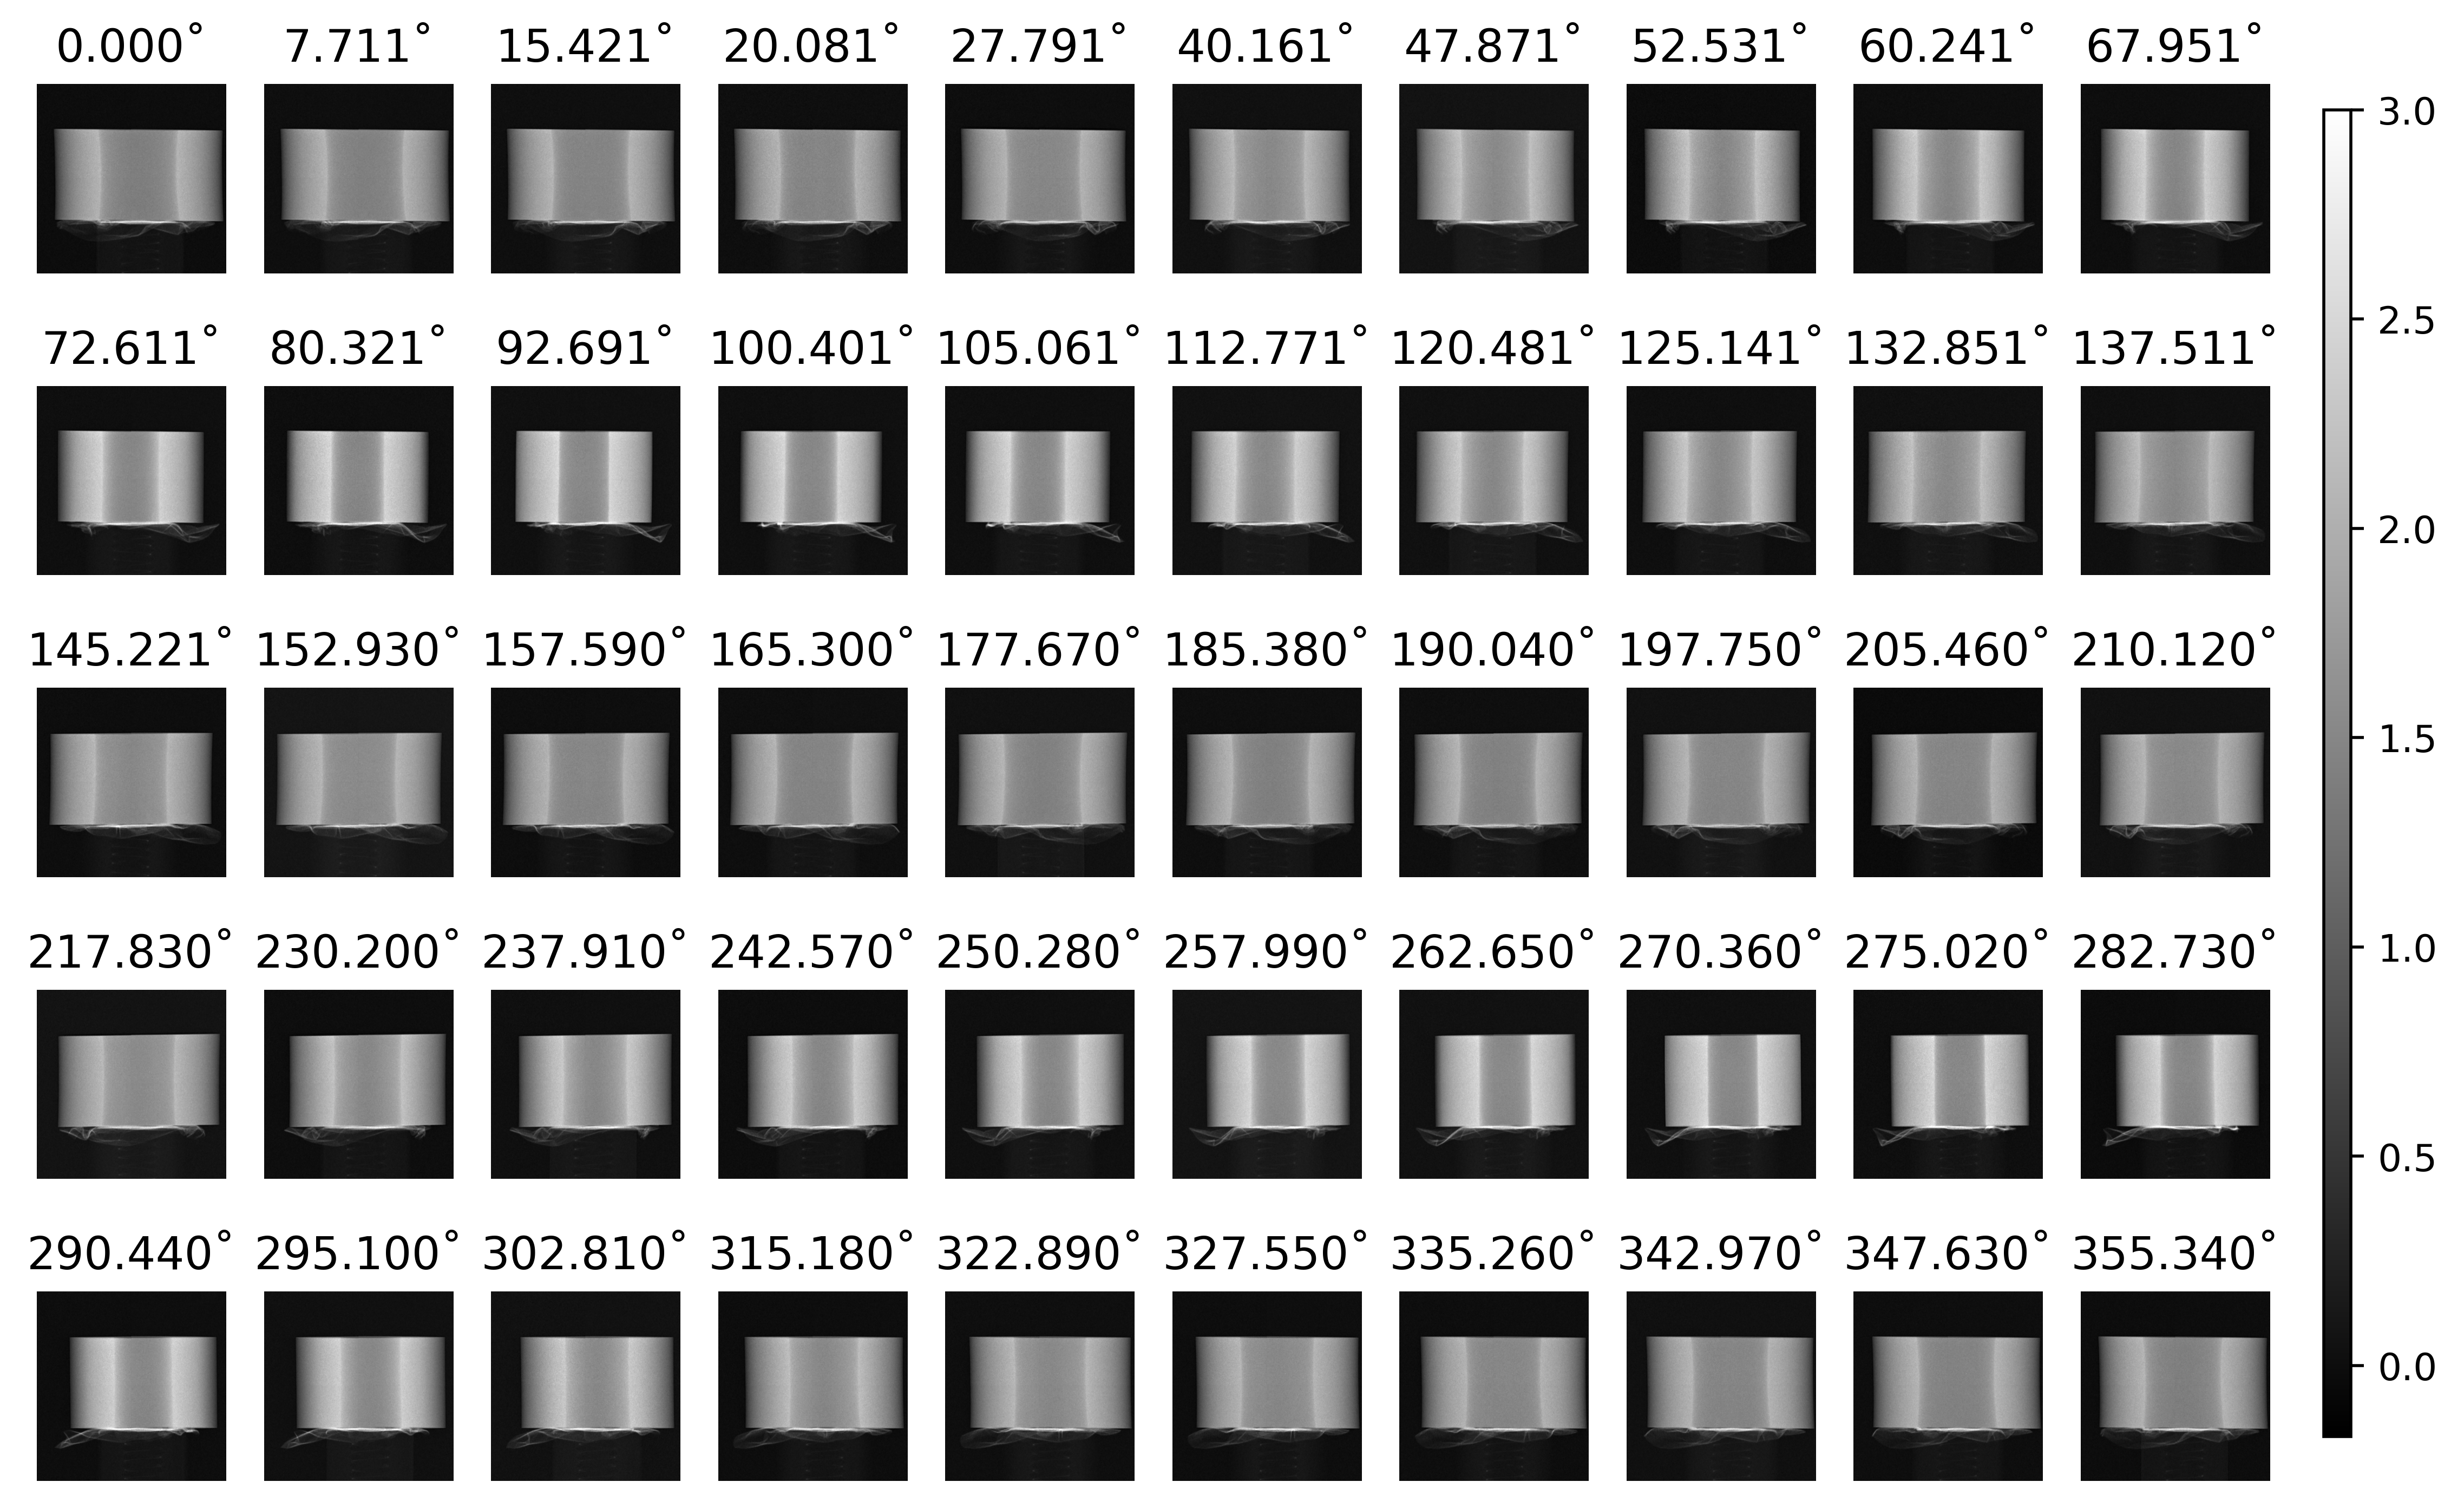

In [9]:
fig, axs = plt.subplots(5,10,figsize=(10, 7), dpi = 500)
for ax, im, ang in zip(axs.flatten(), norm_data, angle_list):
    im = ax.imshow(im, cmap='gray', vmax = 3)
    ax.set_title(f'{ang:.3f}˚')
    ax.set_axis_off()

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, shrink = 0.1)

In [81]:
res_save_path = os.path.join('/home/gxt/Projects/', 'Results', 'wav_{}_{}'.format(50, 800))
utils.dir_check(res_save_path)


'/home/gxt/Projects/Results/wav_50_800 exists!'

In [93]:
idx = [np.argmin(abs(utils.generate_gs_angle(i, max_angle=360)-angle_list)) for i in range(6)]
sino, ang = svmbir.sino_sort(norm_data[idx, 150:200], np.deg2rad(angle_list[idx]), weights=None)

_rec = svmbir.recon(sino, angles=ang,
                    num_rows = 504, num_cols = 504,
                    center_offset = -4, sharpness=cfg['sharpness'],
                    snr_db = cfg['snr_db'], positivity= False, max_iterations = 200,
                    num_threads= 32, verbose=0, svmbir_lib_path = '/tmp',)

quality = Evaluator.CNNEVA(None, _rec[:, 10:490, 80:470], 6, [50], 3, cfg['eva_paras'], res_save_path)

No previous reconstruction to compare!


In [94]:
ResQueues = [[], [], []] #RecScore_Queue, SubseqScore_Queue, QI_Queue
ResQueues = utils.Enqueue(ResQueues, [quality.recon_score, quality.subseq_score, quality.QI])
print(ResQueues)

[[1.1432012], [None], [None]]


In [96]:
for n in tqdm(np.arange(9, 50, 3)):
    _pre_rec = _rec.copy()

    idx = [np.argmin(abs(utils.generate_gs_angle(i, max_angle=360)-angle_list)) for i in range(n)]

    sino, ang = svmbir.sino_sort(norm_data[idx, 150:200], np.deg2rad(angle_list[idx]), weights=None)
    
    _rec = svmbir.recon(sino, angles=ang,
                        num_rows = 504, num_cols = 504,
                        center_offset = -4, sharpness=cfg['sharpness'],
                        snr_db = cfg['snr_db'], positivity= False, max_iterations = 200,
                        num_threads= 32, verbose=0, svmbir_lib_path = '/tmp',)
    
    quality = Evaluator.CNNEVA(_pre_rec[:, 10:490, 80:470], _rec[:, 10:490, 80:470], n, [50], 3, cfg['eva_paras'], res_save_path)
    ResQueues = utils.Enqueue(ResQueues, [quality.recon_score, quality.subseq_score, quality.QI])

100%|██████████| 14/14 [52:12<00:00, 223.78s/it]


In [98]:
_pre_rec = _rec.copy()

idx = [np.argmin(abs(utils.generate_gs_angle(i, max_angle=360)-angle_list)) for i in range(50)]

sino, ang = svmbir.sino_sort(norm_data[idx, 150:200], np.deg2rad(angle_list[idx]), weights=None)

_rec = svmbir.recon(sino, angles=ang,
                    num_rows = 504, num_cols = 504,
                    center_offset = -4, sharpness=cfg['sharpness'],
                    snr_db = cfg['snr_db'], positivity= False, max_iterations = 200,
                    num_threads= 32, verbose=0, svmbir_lib_path = '/tmp',)

quality = Evaluator.CNNEVA(_pre_rec[:, 10:490, 80:470], _rec[:, 10:490, 80:470], 50, [50], 3, cfg['eva_paras'], res_save_path)
ResQueues = utils.Enqueue(ResQueues, [quality.recon_score, quality.subseq_score, quality.QI])

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [104]:
ResQueues[2]

[None,
 array([2.31979375]),
 array([2.23137929]),
 array([2.44158046]),
 array([2.49103563]),
 array([2.29847365]),
 array([2.77469387]),
 array([2.84125671]),
 array([2.78191227]),
 array([2.76296033]),
 array([2.85933682]),
 array([2.86716549]),
 array([2.97260675]),
 array([3.02717469]),
 array([3.0620321])]

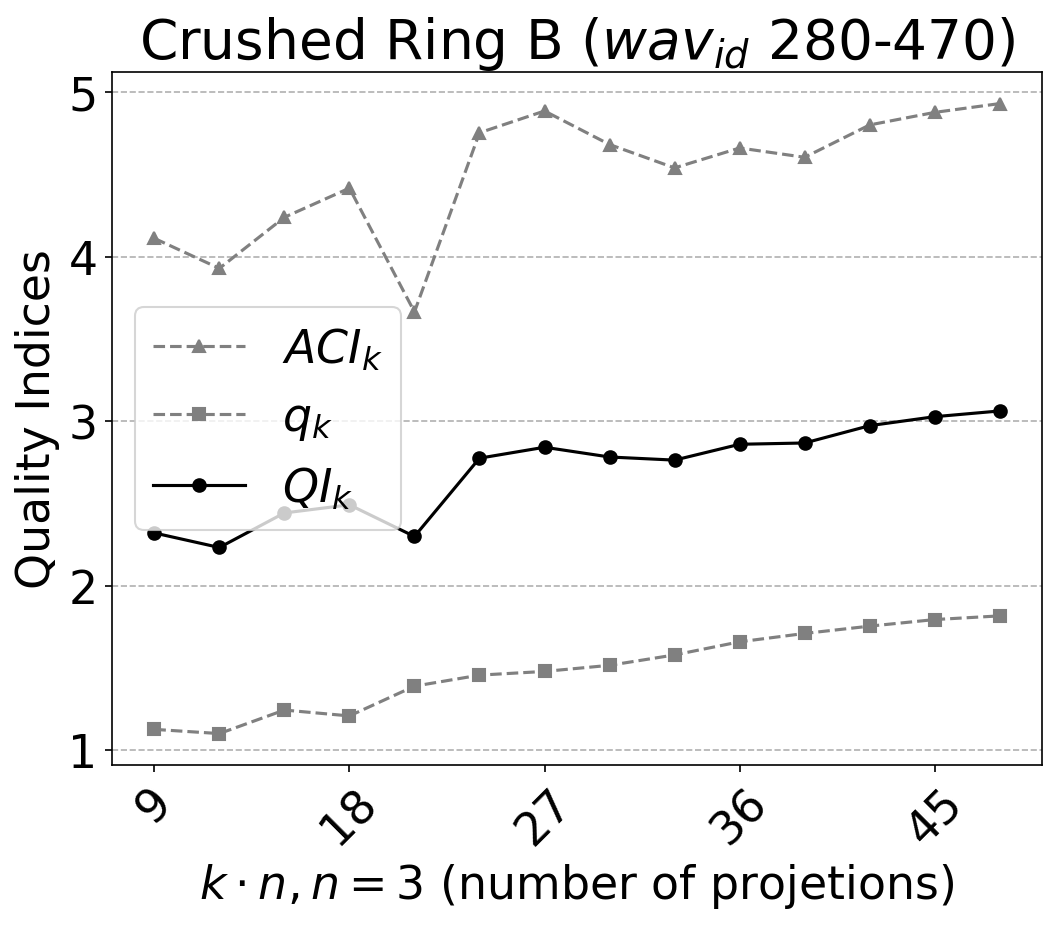

In [107]:
plt.rcParams.update({'font.size': 22})
fig = plt.figure(figsize=(8, 6), dpi = 150)
plt.plot((ResQueues[1][1:]), '--^', color = 'gray', label = '$ACI_{k}$')
plt.plot(ResQueues[0][1:], '--s', color = 'gray', label = '$q_{k}$')
plt.plot(ResQueues[2][1:], 'k-o', label = '$QI_{k}$')
plt.legend(fontsize= 22)
plt.grid(axis='y', linestyle = '--')
plt.xticks(np.arange(0, 15, step=3),  [str(9+3*(k)) for k in np.arange(0, 15, step=3)], rotation = 45)
plt.ylabel('Quality Indices', fontsize= 22)
plt.xlabel('$k \cdot n, n = 3$ (number of projetions)', fontsize= 22)
plt.title('Crushed Ring B ($wav_{id}$ 280-470)')
plt.show()

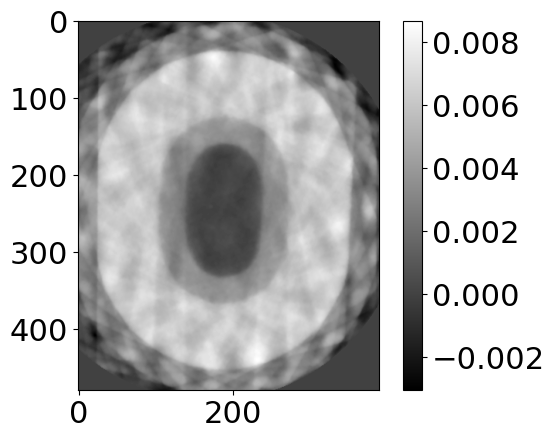

In [108]:
plt.imshow(_rec[5, 10:490, 80:470], cmap = 'gray')
plt.colorbar()

In [ ]:
run = AIRobo(cfg_file, 'angle', 1, angle_mode = 'preset')

In [ ]:
run = AIRobo(cfg_file, 'recon', 1)

In [5]:
_rec = svmbir.recon(sino = norm_data[:, 200:210], angles=np.deg2rad(angle_list),
                    num_rows = 504, num_cols = 504,
                    center_offset = -4, sharpness=cfg['sharpness'],
                    snr_db = cfg['snr_db'], positivity= True, max_iterations = 200,
                    num_threads= 64, verbose=1, svmbir_lib_path = '/tmp',)

NameError: name 'norm_data' is not defined

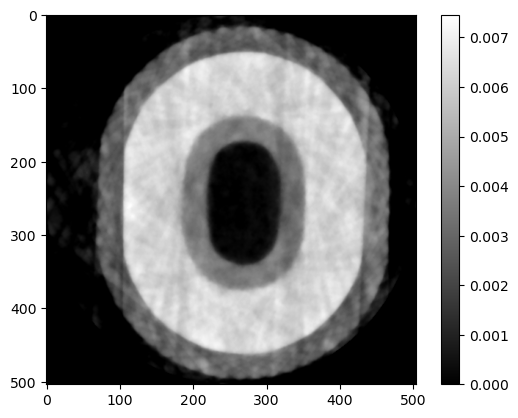

In [36]:
plt.imshow(_rec[5], cmap = 'gray')
plt.colorbar()

In [3]:
# load existed reconstruction
rec_file = '/storage/VENUS/IPTS-33531/shared/ai_outputs/November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin_02_50C/Recons/wav_270_480/Ang_num_050.tiff'

rec = imread(rec_file).astype(np.float32)


In [4]:
rec.shape

(150, 503, 503)

In [11]:
angle_list = np.deg2rad(np.array([7.71082381, 242.5702746, 360, 15.42080578, 237.9102855, 355.3400109, 20.08079488, 230.2003035, 
                       347.6300289, 27.79077685, 217.8303325, 342.9700398, 40.16074792, 210.1203505, 335.2600579, 
                       47.87072989, 205.4603614, 327.5500759, 52.530719, 197.7503794, 322.8900868, 60.24070097, 
                       190.0403974, 315.1801048, 67.95068294, 185.3804083, 302.8101337, 72.61067204, 177.6704264, 
                       295.1001518, 80.32065401, 165.3004553, 290.4401627, 92.69062509, 157.5904733, 282.7301807, 
                       100.4006071, 152.9304842, 275.0201987, 105.0605962, 145.2205023, 270.3602096, 112.7705781, 
                       137.5105203, 262.6502277, 120.4805601, 132.8505312, 257.9902385, 125.1405492, 250.2802566]))
angle_list.sort()

In [12]:
sino = svmbir.project(rec, angle_list, num_channels=503, geometry='parallel')

Computing system matrix...
Writing system matrix...


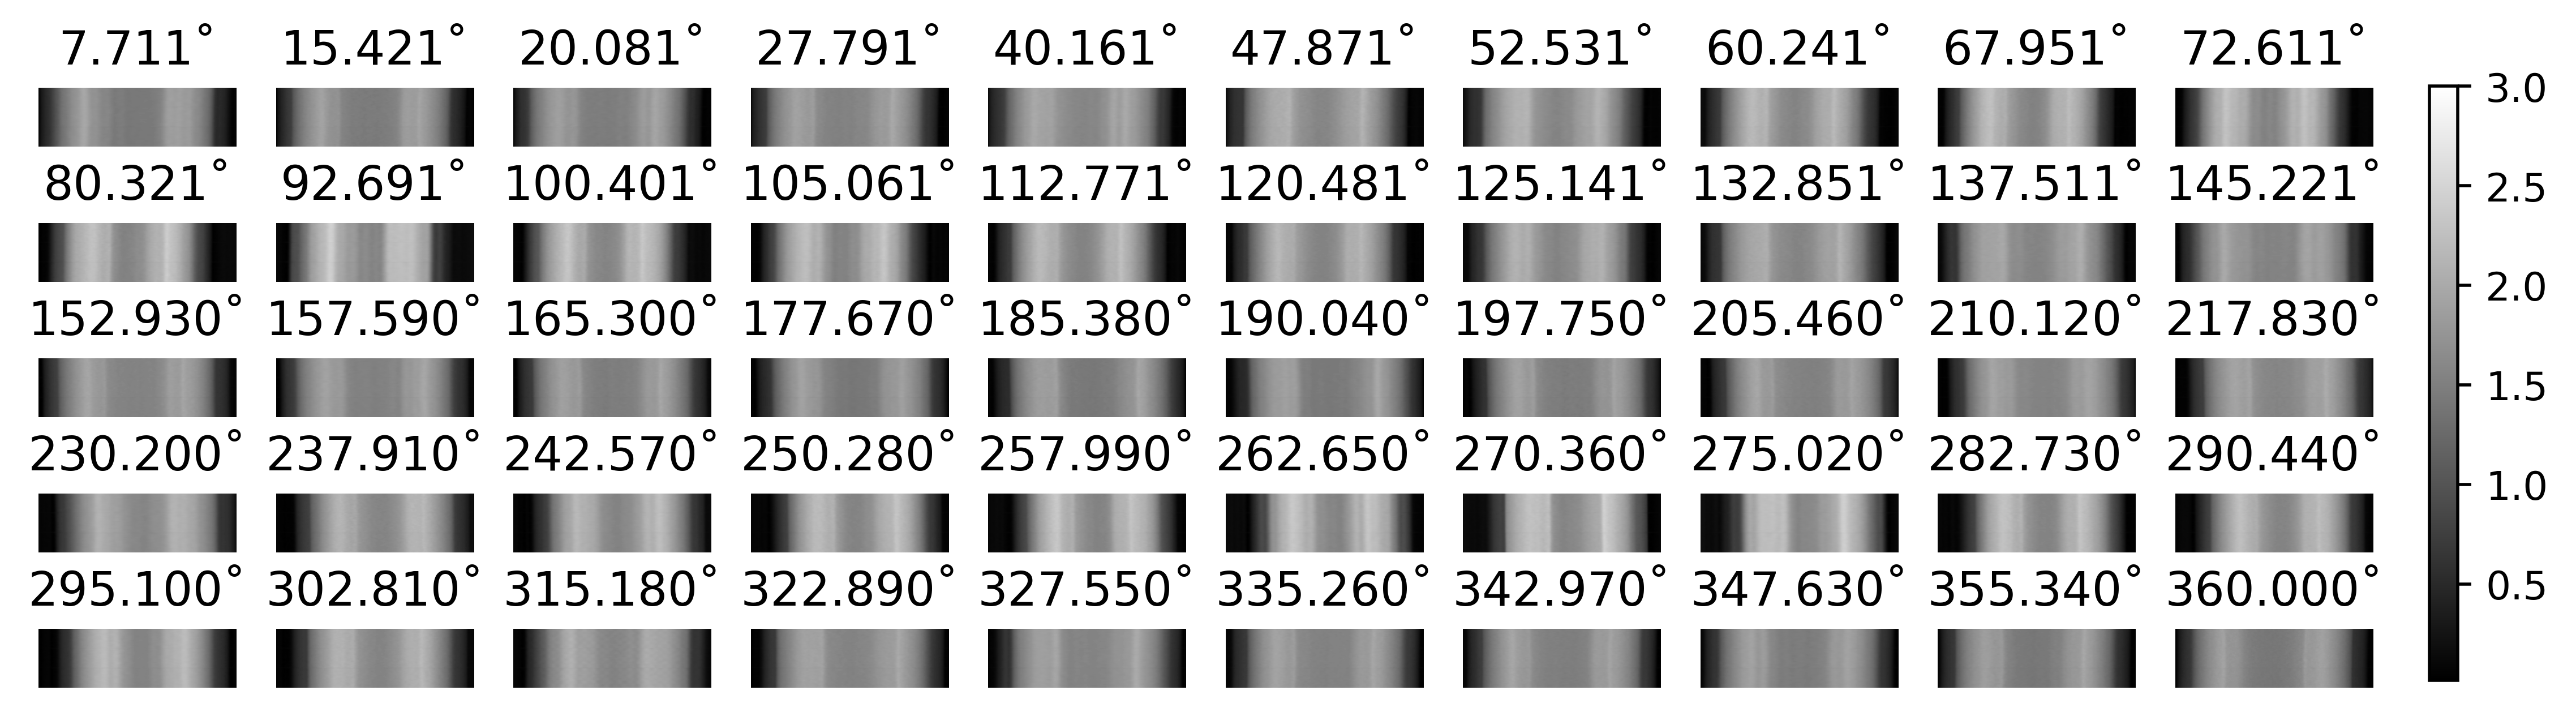

In [19]:
fig, axs = plt.subplots(5,10,figsize=(10, 3), dpi = 500)
for ax, im, ang in zip(axs.flatten(),sino, np.rad2deg(angle_list)):
    im = ax.imshow(im, cmap='gray', vmax = 3)
    ax.set_title(f'{ang:.3f}˚')
    ax.set_axis_off()

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, shrink = 0.1)

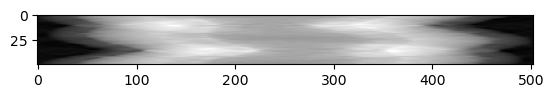

In [14]:
plt.imshow(sino[:, 75], cmap = 'gray')

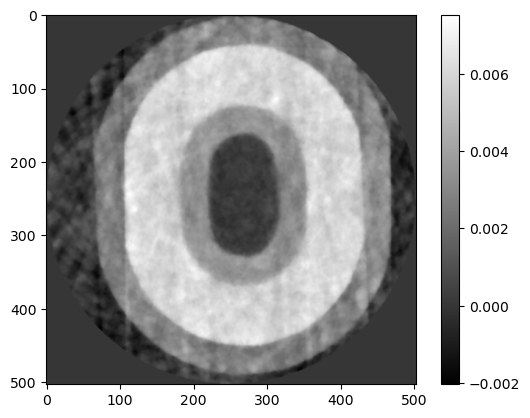

In [21]:
rec = imread('/storage/VENUS/IPTS-33531/shared/ai_outputs/November22_CrushedRing_B_hyperCT_60Hz_1_8Angsmin_02_50C/Recons/wav_270_480/Ang_num_050.tiff')
plt.imshow(rec[15], cmap = 'gray')
plt.colorbar()

In [ ]:
# if need rotation center
rot_center = tomopy.find_center_pc(np.squeeze(norm_data[0,]),
                                   np.squeeze(norm_data[1,]), tol=0.5)
center_offset = -(norm_data.shape[2]/2 - rot_center)
print(f'center rotation is {center_offset}')